In [1]:
import numpy as np
import pandas as pd
from datetime import *

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [11]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.1.0


## Get data

In [12]:
with open('steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'c{i}' for i in range(ns)]
steps_d = [f'd{i}' for i in range(ns)]
steps_ = steps_c + steps_d

In [13]:
df = pd.read_csv(
    'combined_data_step-7.csv',
    dtype={'fips': str}).set_index('fips')
df.rename(columns={steps[i] + '_c': steps_c[i] for i in range(ns)}, inplace=True)
df.rename(columns={steps[i] + '_d': steps_d[i] for i in range(ns)}, inplace=True)
df.head()

,65yrs,minority,black,hispanic,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,poverty,...,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30
fips,,,,,,,,,,,,,,,,,,,,,
01001,8924,13262,11237,1671,55869,0.159731,0.237377,0.201131,0.029909,7587,...,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,3.0,0.0
01003,46830,28036,19593,10534,223234,0.209780,0.125590,0.087769,0.047188,21069,...,4.0,6.0,1.0,6.0,1.0,3.0,12.0,2.0,2.0,2.0
01005,4861,12552,11906,1117,24686,0.196913,0.508466,0.482298,0.045248,6788,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01007,3733,5203,4763,623,22394,0.166696,0.232339,0.212691,0.027820,4400,...,0.0,0.0,0.0,4.0,0.0,0.0,2.0,1.0,1.0,1.0
01009,10814,2414,978,5582,57826,0.187009,0.041746,0.016913,0.096531,7527,...,3.0,3.0,1.0,1.0,1.0,0.0,1.0,7.0,2.0,0.0


In [14]:
steps_vec = [x.split('-') for x in steps]
steps = [f'2020-{m.zfill(2)}-{d.zfill(2)}' for m, d in steps_vec]

last = datetime.strptime(steps[-1], '%Y-%m-%d')
next_1 = (last + timedelta(days=7)).date()
next_2 = (last + timedelta(days=14)).date()

print(next_1, next_2)

2020-11-07 2020-11-14


In [15]:
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk', 
    'risk_flu',
    'urban_risk'
]

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk,risk_flu,urban_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12,7.0,6.0,11.0,9.0,23.0,42.0,45.0,61.0,43.0,...,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,0.984276,1.006875,0.666999
01003,29,37.0,43.0,38.0,34.0,35.0,38.0,19.0,10.0,21.0,...,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.225361,1.296454,0.817850
01005,2,7.0,9.0,14.0,11.0,15.0,21.0,26.0,45.0,40.0,...,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.221392,0.420657,-0.240836
01007,4,9.0,13.0,8.0,8.0,3.0,5.0,8.0,14.0,5.0,...,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.308118,0.436170,-0.249735
01009,10,2.0,8.0,11.0,9.0,4.0,1.0,4.0,12.0,9.0,...,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.566669,0.617627,-0.724261


## Get GLM predictions

In [16]:
cov_prefix = 'population+perc_65yrs+perc_minority+perc_black+perc_hispanic+perc_poverty+income+'
cov = cov_prefix + 'perc_urban_pop+risk_flu+urban_risk'

In [51]:
def save_table(model, tab_fname):
    results_as_html = model.summary().tables[1].as_html()
    summary = pd.read_html(results_as_html, header=0, index_col=0)[0]    
    func = lambda x: f'${x:.4f}$'
    table = summary.to_latex(formatters={col: func for col in summary.columns}, escape=False)
    
    table = table.replace('perc_65yrs', '$\%65+$')
    table = table.replace('0.0000', '0')
    table = table.replace('0.', '.').replace('perc_', '$\%$').replace('_pop', '').replace('_flu', '')
    table = table.replace('z', '$z$').replace('P>|z|', '$P>|z|$')
    table = table.replace('[.025', '$[.025$').replace('.975]', '$.975]$')
    
    # print(table)
    with open(tab_fname, 'w') as handle:
        handle.write(table)

### COVID case 

In [52]:
cors = []
for i in range(len(steps_c)):
# for i in range(1):
    cur = steps_c[i]
    formula = f'{cur}~{cov}'

    # Model fitting
    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    print(cor)
    cors.append(cor)
    
    df_z[cur + '_p'] = model.predict()
    
    tab_fname = f'../../COVID_risk/tables/{steps[i]}_case.tab'
    save_table(model, tab_fname)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     c0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1220e+05
Date:                Thu, 05 Nov 2020   Deviance:                   4.1454e+05
Time:                        00:23:32   Pearson chi2:                 7.18e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.0954      0.007    280.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     c6   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 05 Nov 2020   Deviance:                   1.7663e+05
Time:                        00:23:33   Pearson chi2:                 3.51e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.4768      0.007    357.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    c12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 05 Nov 2020   Deviance:                   2.4279e+05
Time:                        00:23:33   Pearson chi2:                 3.29e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.8642      0.006    475.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    c18   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 05 Nov 2020   Deviance:                   2.0461e+05
Time:                        00:23:34   Pearson chi2:                 2.73e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5871      0.004    908.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    c24   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 05 Nov 2020   Deviance:                   2.5173e+05
Time:                        00:23:34   Pearson chi2:                 2.76e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6654      0.004   1006.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    c30   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 05 Nov 2020   Deviance:                   2.9960e+05
Time:                        00:23:35   Pearson chi2:                 3.87e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.3107      0.003   1718.

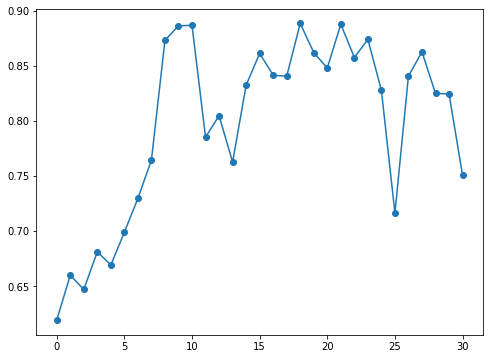

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

### COVID death

In [54]:
cors = []
for i in range(len(steps_d)):
    cur = steps_d[i]
    formula = f'{cur}~{cov}'

    # Model fitting
    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    print(cor)
    cors.append(cor)
    
    df_z[cur + '_p'] = model.predict()
    
    tab_fname = f'../../COVID_risk/tables/{steps[i]}_death.tab'
    save_table(model, tab_fname)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     d0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10256.
Date:                Thu, 05 Nov 2020   Deviance:                       18471.
Time:                        00:23:40   Pearson chi2:                 5.64e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.3321      0.050    -46.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     d6   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 05 Nov 2020   Deviance:                       16673.
Time:                        00:23:41   Pearson chi2:                 3.94e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6402      0.034    -18.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    d12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 05 Nov 2020   Deviance:                       13057.
Time:                        00:23:41   Pearson chi2:                 2.78e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1279      0.042    -26.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    d18   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 05 Nov 2020   Deviance:                       10056.
Time:                        00:23:42   Pearson chi2:                 1.17e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5723      0.032    -18.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    d24   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 05 Nov 2020   Deviance:                       8435.6
Time:                        00:23:42   Pearson chi2:                 1.01e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3627      0.027    -13.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    d30   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 05 Nov 2020   Deviance:                       8370.0
Time:                        00:23:43   Pearson chi2:                 9.38e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0075      0.021     -0.

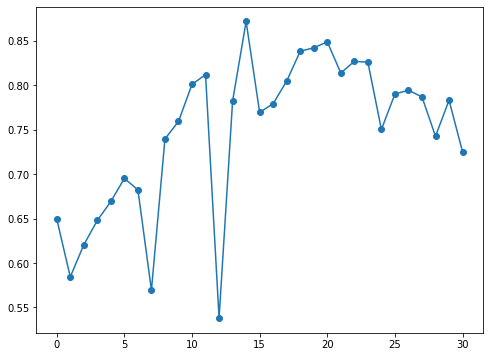

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

## Forecast

### make tensorflow regressor a little easier to use

In [13]:
class tfRegr:
    
    def __init__(self, 
                 epoch=100, 
                 verbose=False, 
                 validation_split=0.2, 
                 learning_rate=.1):
        
        self.normalizer = preprocessing.Normalization()
        self.ep = epoch
        self.vb = verbose
        self.vs = validation_split
        self.lr = learning_rate
    
    def fit(self, X, y):
        self.normalizer.adapt(X)

        self.model = tf.keras.Sequential([
            self.normalizer,
            layers.Dense(units=1)
        ])

        self.model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=self.lr),
            loss='mean_absolute_error'
        )

        self.history = self.model.fit(
            X, y,
            epochs=self.ep,
            verbose=self.vb, # logging
            validation_split=self.vs # Calculate validation results on a fraction of the training data
        )
        return self.model

## Functions

In [55]:
def predict_k_steps(k=1, plan='plain', verbose=False):

    regrs = {
        'RF': RandomForestRegressor(min_samples_split=2), 
        'ET': ExtraTreesRegressor(min_samples_split=2), 
        'TF': tfRegr(),
    }
    
    r2s = {regr_name: [] for regr_name in regrs}
    # for i in range(k, len(steps_c)):
    for i in range(k, k + 1):

        cur_idx = int(steps_c[i][1:])
        cur, nxt = steps_c[i], f'c{cur_idx + k}'

        print(f'{steps[i]}:')

        # Training regressor
        if plan == 'plain':
            cols = [f'c{cur_idx - k}'] + [f'c{cur_idx - k}_p']
        elif plan == 'tweak':
            cols = [f'c{cur_idx - k}'] + [f'c{cur_idx - i}_p' for i in range(k + 1)]
        else:
            print('wrong plan name')
            return
        
        X_train = df_data[cols].values
        y_train = df_data[cur].values 

        for regr_name, regr in regrs.items():
            regr = regr.fit(X_train, y_train)

            # Predicting next k step
            if plan == 'plain':
                cols = [cur] + [f'c{cur_idx}_p']
            elif plan == 'tweak':
                cols = [cur] + [f'c{cur_idx - i}_p' for i in range(k + 1)]
    
            X_nxt = df_data[cols].values
            y_nxt = regr.predict(X_nxt)
            
            y_nxt = y_nxt.flatten()

            df_data[cur + f'_{k}p{regr_name}'] = y_nxt
            
            # evaluating and showing results
            if i < len(steps_c) - k:
                y_test = df_data[nxt].values
                r2 = r2_score(y_test, y_nxt)
                r2s[regr_name].append(r2)
                
                diff_col = f'{cur}_{k}p{regr_name}_diff'
                df_data[diff_col] = y_test - y_nxt
                
                if verbose:
                    print(f'\t{regr_name}, next {k}: sum = {y_test.sum():.0f}, predicted sum = {y_nxt.sum():.0f}, r2 = {r2: .3f}')
            else:
                if verbose:
                    print(f'\t{regr_name}, next {k}: predicted sum = {y_nxt.sum():.0f}')

    print(f'next {k} week r2s')
    for regr_name, r2_arr in r2s.items():
        r2_arr = np.array(r2_arr)
        print(f'\t{regr_name}: {r2_arr.mean(): .3f}')

In [35]:
def predict_k_steps_death(k=1, plan='plain', verbose=False):

    regrs = {
        'RF': RandomForestRegressor(min_samples_split=50), 
        'ET': ExtraTreesRegressor(min_samples_split=50), 
        'TF': tfRegr(),
    }
    
    r2s = {regr_name: [] for regr_name in regrs}
    for i in range(k, len(steps_d)):
    # for i in range(k, k + 1):

        cur_idx = int(steps_d[i][1:])
        cur, nxt = steps_d[i], f'd{cur_idx + k}'

        print(f'{steps[i]}:')

        # Training regressor
        if plan == 'plain':
            cols = [f'd{cur_idx - k}', f'c{cur_idx - k}'] + [f'd{cur_idx - k}_p', f'c{cur_idx - k}_p']
        elif plan == 'tweak':
            cols = [f'd{cur_idx - k}', f'c{cur_idx - k}']\
                + [f'd{cur_idx - i}_p' for i in range(k + 1)]\
                + [f'c{cur_idx - i}_p' for i in range(k + 1)]
        else:
            print('wrong plan name')
            return
        
        X_train = df_data[cols].values
        y_train = df_data[cur].values 
        
        # print(X_train[:10])
        # print(y_train[:10])

        for regr_name, regr in regrs.items():
            regr = regr.fit(X_train, y_train)

            # Predicting next k step
            if plan == 'plain':
                cols = [f'd{cur_idx}', f'c{cur_idx}'] + [f'd{cur_idx}_p', f'c{cur_idx}_p']
            elif plan == 'tweak':
                cols = [f'd{cur_idx}', f'c{cur_idx}']\
                    + [f'd{cur_idx - i}_p' for i in range(k + 1)]\
                    + [f'c{cur_idx - i}_p' for i in range(k + 1)]
    
            X_nxt = df_data[cols].values
            y_nxt = regr.predict(X_nxt)
            
            y_nxt = y_nxt.flatten()

            df_data[cur + f'_{k}p{regr_name}'] = y_nxt
            
            # evaluating and showing results
            if i < len(steps_d) - k:
                y_test = df_data[nxt].values
                r2 = r2_score(y_test, y_nxt)
                r2s[regr_name].append(r2)
                
                diff_col = f'{cur}_{k}p{regr_name}_diff'
                df_data[diff_col] = y_test - y_nxt
                
                if verbose:
                    print(f'\t{regr_name}, next {k}: sum = {y_test.sum():.0f}, predicted sum = {y_nxt.sum():.0f}, r2 = {r2: .3f}')
            else:
                if verbose:
                    print(f'\t{regr_name}, next {k}: predicted sum = {y_nxt.sum():.0f}')

    print(f'next {k} week r2s')
    for regr_name, r2_arr in r2s.items():
        r2_arr = np.array(r2_arr)
        print(f'\t{regr_name}: {r2_arr.mean(): .3f}')

In [29]:
def get_mse_summary(df_data, target, horizon, methods):
    
    print('\n#========================== MSE Summary ==========================START')
    results = {method: [] for method in methods}
    for i in range(1, len(steps)):
        for method in methods:
            diff_col = f'{target}{i}_1p{method}_diff'
            if diff_col in df_data:
                diff = df_data[diff_col]
                mse = np.sqrt((diff**2).mean())
                results[method].append(mse)
                print(f'{i}, {method}: {mse:.0f}')
        print('\n---------------------')

    for key, val in results.items():
        print(f'{key} average: {np.mean(val):.0f}')
    print('#========================== MSE Summary ==========================END\n')

## Forecast Runs

### Case

### Death

In [38]:
num_runs = 20
plan = 'tweak'
methods = ['ET', 'RF', 'TF']

In [39]:
for r in range(0, num_runs):
    # Get data
    df_data = df_z[steps_ + [x + '_p' for x in steps_]].copy()
    
    # Predict
    predict_k_steps_death(k=1, plan=plan, verbose=True)   
    
    # Save county-wise prediction
    df_data.to_csv(f'results_forecast/forecaset_county_death_{plan}_{str(r).zfill(2)}.csv', float_format='%.2f')
    
    # Get summary in mse for each step
    get_mse_summary(df_data, 'd', 1, methods)
    
    # Get US counts
    srs = []
    grd = df_data[[f'd{i}' for i in range(len(steps_d))]].sum()
    grd.name = 'grd'
    srs.append(grd)

    for key in ['ET', 'RF', 'TF']:
        cols = [x for x in df_data.columns if x.endswith(f'_1p{key}')]
        sr = df_data[cols].sum().astype(int)
        sr.index = [x.split('_')[0] for x in sr.index]
        sr.name = key + '1'
        srs.append(sr)

    df_count = pd.concat(srs, join='outer', axis=1)
    df_count.index = [int(s[1:]) for s in df_count.index]
    df_count.sort_index(inplace=True)

    grd1 = df_count['grd'][2: ]
    grd1.index = range(1, len(grd1) + 1)
    grd1.name = 'grd1'

    df_count = df_count.join(grd1, how='outer')
    df_count.index = steps
    df_count.drop(steps[0], inplace=True)
    
    df_count['avg1'] = df_count[[f'{key}1' for key in ['ET', 'TF', 'RF']]].mean(axis=1)
    df_count['med1'] = df_count[[f'{key}1' for key in ['ET', 'TF', 'RF']]].median(axis=1)
    
    df_count.to_csv(f'results_forecast/forecast_US_death_{plan}_{str(r).zfill(2)}.csv', float_format='%0.f')
    
#     # plot US count
#     xtl = list(df_count.index[1:].values) + [next_1]

#     ylim = np.array([np.nanmin(df_count.values), np.nanmax(df_count.values)])
#     margin = (ylim[1] - ylim[0]) * .05
#     ylim = [ylim[0] - margin, ylim[1] + margin]

#     fig, axes = plt.subplots(2, 1, figsize=(18, 12),sharex=True)
#     ax = axes[0]

#     df_count[[f'grd1']].plot(ax=ax, marker='o', linewidth=4)
#     df_count[[f'avg1']].plot(ax=ax, marker='o', linewidth=4)
#     df_count[[f'med1']].plot(ax=ax, marker='o', linewidth=4)

#     for method in ['ET', 'TF', 'RF']:
#         tmp_df = df_count[[f'{method}1']]
#         tmp_df.plot(ax=ax, marker='o')

#     ax.set_ylim(ylim)
#     ax.set_xticks(range(len(xtl)))
#     # ax.set_xticklabels(xtl, rotation=45, ha='center')

#     ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#     ax.tick_params(axis='both', labelsize=15)
#     ax.legend(prop=dict(size=14))

#     df_count_cumul = df_count.cumsum(axis=0)

#     ylim = np.array([np.nanmin(df_count_cumul.values), np.nanmax(df_count_cumul.values)])
#     margin = (ylim[1] - ylim[0]) * .05
#     ylim = [ylim[0] - margin, ylim[1] + margin]

#     ax = axes[1]
#     df_count_cumul[[f'grd1']].plot(ax=ax, marker='o', linewidth=4)
#     df_count_cumul[[f'avg1']].plot(ax=ax, marker='o', linewidth=4)
#     df_count_cumul[[f'med1']].plot(ax=ax, marker='o', linewidth=4)
#     for method in ['ET', 'TF', 'RF']:
#         tmp_df = df_count_cumul[[f'{method}1']]
#         tmp_df.plot(ax=ax, marker='o')

#     ax.set_ylim(ylim)
#     ax.set_xticks(range(len(xtl)))
#     ax.set_xticklabels(xtl, rotation=45, ha='center')

#     ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#     ax.tick_params(axis='both', labelsize=15)
#     ax.legend(prop=dict(size=14))

2020-04-11:
	RF, next 1: sum = 13657, predicted sum = 10993, r2 =  0.801
	ET, next 1: sum = 13657, predicted sum = 11131, r2 =  0.811
	TF, next 1: sum = 13657, predicted sum = 12348, r2 =  0.927
2020-04-18:
	RF, next 1: sum = 14460, predicted sum = 14010, r2 =  0.908
	ET, next 1: sum = 14460, predicted sum = 14103, r2 =  0.937
	TF, next 1: sum = 14460, predicted sum = 13594, r2 =  0.927
2020-04-25:
	RF, next 1: sum = 13134, predicted sum = 15261, r2 =  0.813
	ET, next 1: sum = 13134, predicted sum = 15571, r2 =  0.869
	TF, next 1: sum = 13134, predicted sum = 13849, r2 =  0.892
2020-05-02:
	RF, next 1: sum = 11732, predicted sum = 12641, r2 =  0.855
	ET, next 1: sum = 11732, predicted sum = 12495, r2 =  0.895
	TF, next 1: sum = 11732, predicted sum = 12056, r2 =  0.911
2020-05-09:
	RF, next 1: sum = 9764, predicted sum = 11354, r2 =  0.724
	ET, next 1: sum = 9764, predicted sum = 11024, r2 =  0.809
	TF, next 1: sum = 9764, predicted sum = 10454, r2 =  0.932
2020-05-16:
	RF, next 1: sum

	TF, next 1: sum = 9764, predicted sum = 10095, r2 =  0.935
2020-05-16:
	RF, next 1: sum = 12568, predicted sum = 8894, r2 =  0.207
	ET, next 1: sum = 12568, predicted sum = 8720, r2 =  0.214
	TF, next 1: sum = 12568, predicted sum = 7413, r2 =  0.235
2020-05-23:
	RF, next 1: sum = 6635, predicted sum = 11524, r2 = -4.154
	ET, next 1: sum = 6635, predicted sum = 11789, r2 = -1.904
	TF, next 1: sum = 6635, predicted sum = 9954, r2 = -3.192
2020-05-30:
	RF, next 1: sum = 6253, predicted sum = 5994, r2 =  0.826
	ET, next 1: sum = 6253, predicted sum = 6282, r2 =  0.843
	TF, next 1: sum = 6253, predicted sum = 6038, r2 =  0.764
2020-06-06:
	RF, next 1: sum = 5181, predicted sum = 5724, r2 =  0.671
	ET, next 1: sum = 5181, predicted sum = 6020, r2 =  0.849
	TF, next 1: sum = 5181, predicted sum = 5656, r2 =  0.894
2020-06-13:
	RF, next 1: sum = 4256, predicted sum = 4807, r2 =  0.879
	ET, next 1: sum = 4256, predicted sum = 4761, r2 =  0.915
	TF, next 1: sum = 4256, predicted sum = 4661, r2

	TF, next 1: sum = 4256, predicted sum = 4418, r2 =  0.901
2020-06-20:
	RF, next 1: sum = 5771, predicted sum = 3687, r2 =  0.290
	ET, next 1: sum = 5771, predicted sum = 3819, r2 =  0.330
	TF, next 1: sum = 5771, predicted sum = 4188, r2 =  0.320
2020-06-27:
	RF, next 1: sum = 3624, predicted sum = 6070, r2 =  0.051
	ET, next 1: sum = 3624, predicted sum = 6104, r2 =  0.283
	TF, next 1: sum = 3624, predicted sum = 3887, r2 = -0.075
2020-07-04:
	RF, next 1: sum = 4998, predicted sum = 3524, r2 =  0.661
	ET, next 1: sum = 4998, predicted sum = 3767, r2 =  0.688
	TF, next 1: sum = 4998, predicted sum = 3540, r2 =  0.749
2020-07-11:
	RF, next 1: sum = 5401, predicted sum = 5757, r2 =  0.829
	ET, next 1: sum = 5401, predicted sum = 5699, r2 =  0.843
	TF, next 1: sum = 5401, predicted sum = 5827, r2 =  0.802
2020-07-18:
	RF, next 1: sum = 6315, predicted sum = 5588, r2 =  0.840
	ET, next 1: sum = 6315, predicted sum = 5793, r2 =  0.815
	TF, next 1: sum = 6315, predicted sum = 5139, r2 =  0.

	TF, next 1: sum = 6315, predicted sum = 5391, r2 =  0.891
2020-07-25:
	RF, next 1: sum = 7785, predicted sum = 6427, r2 =  0.657
	ET, next 1: sum = 7785, predicted sum = 6815, r2 =  0.680
	TF, next 1: sum = 7785, predicted sum = 6331, r2 =  0.791
2020-08-01:
	RF, next 1: sum = 7032, predicted sum = 7944, r2 =  0.813
	ET, next 1: sum = 7032, predicted sum = 8387, r2 =  0.850
	TF, next 1: sum = 7032, predicted sum = 6884, r2 =  0.860
2020-08-08:
	RF, next 1: sum = 7153, predicted sum = 6187, r2 =  0.793
	ET, next 1: sum = 7153, predicted sum = 6438, r2 =  0.811
	TF, next 1: sum = 7153, predicted sum = 6910, r2 =  0.907
2020-08-15:
	RF, next 1: sum = 6811, predicted sum = 6993, r2 =  0.837
	ET, next 1: sum = 6811, predicted sum = 7163, r2 =  0.822
	TF, next 1: sum = 6811, predicted sum = 6470, r2 =  0.915
2020-08-22:
	RF, next 1: sum = 6233, predicted sum = 6604, r2 =  0.752
	ET, next 1: sum = 6233, predicted sum = 6306, r2 =  0.840
	TF, next 1: sum = 6233, predicted sum = 5392, r2 =  0.

	TF, next 1: sum = 6233, predicted sum = 5891, r2 =  0.868
2020-08-29:
	RF, next 1: sum = 5741, predicted sum = 5927, r2 =  0.748
	ET, next 1: sum = 5741, predicted sum = 5943, r2 =  0.796
	TF, next 1: sum = 5741, predicted sum = 5479, r2 =  0.822
2020-09-05:
	RF, next 1: sum = 5018, predicted sum = 5478, r2 =  0.700
	ET, next 1: sum = 5018, predicted sum = 5511, r2 =  0.760
	TF, next 1: sum = 5018, predicted sum = 4805, r2 =  0.818
2020-09-12:
	RF, next 1: sum = 5586, predicted sum = 4561, r2 =  0.768
	ET, next 1: sum = 5586, predicted sum = 4550, r2 =  0.755
	TF, next 1: sum = 5586, predicted sum = 2771, r2 =  0.697
2020-09-19:
	RF, next 1: sum = 5111, predicted sum = 6423, r2 =  0.635
	ET, next 1: sum = 5111, predicted sum = 6194, r2 =  0.674
	TF, next 1: sum = 5111, predicted sum = 5428, r2 =  0.779
2020-09-26:
	RF, next 1: sum = 4772, predicted sum = 4914, r2 =  0.792
	ET, next 1: sum = 4772, predicted sum = 4949, r2 =  0.817
	TF, next 1: sum = 4772, predicted sum = 3731, r2 =  0.

	TF, next 1: sum = 4772, predicted sum = 4186, r2 =  0.761
2020-10-03:
	RF, next 1: sum = 4877, predicted sum = 4526, r2 =  0.753
	ET, next 1: sum = 4877, predicted sum = 4626, r2 =  0.757
	TF, next 1: sum = 4877, predicted sum = 3252, r2 =  0.728
2020-10-10:
	RF, next 1: sum = 4822, predicted sum = 5098, r2 =  0.664
	ET, next 1: sum = 4822, predicted sum = 5028, r2 =  0.694
	TF, next 1: sum = 4822, predicted sum = 4090, r2 =  0.688
2020-10-17:
	RF, next 1: sum = 5477, predicted sum = 4986, r2 =  0.518
	ET, next 1: sum = 5477, predicted sum = 4911, r2 =  0.585
	TF, next 1: sum = 5477, predicted sum = 4280, r2 =  0.697
2020-10-24:
	RF, next 1: sum = 5575, predicted sum = 6014, r2 =  0.654
	ET, next 1: sum = 5575, predicted sum = 5934, r2 =  0.643
	TF, next 1: sum = 5575, predicted sum = 4366, r2 =  0.615
2020-10-31:
	RF, next 1: predicted sum = 6086
	ET, next 1: predicted sum = 6003
	TF, next 1: predicted sum = 4707
next 1 week r2s
	RF:  0.559
	ET:  0.647
	TF:  0.602

#=================

	TF, next 1: predicted sum = 4455
next 1 week r2s
	RF:  0.538
	ET:  0.669
	TF:  0.612

#========================== MSE Summary ==========================START
1, ET: 14
1, RF: 15
1, TF: 10

---------------------
2, ET: 8
2, RF: 11
2, TF: 8

---------------------
3, ET: 10
3, RF: 12
3, TF: 8

---------------------
4, ET: 7
4, RF: 9
4, TF: 7

---------------------
5, ET: 7
5, RF: 9
5, TF: 4

---------------------
6, ET: 41
6, RF: 42
6, TF: 41

---------------------
7, ET: 15
7, RF: 25
7, TF: 22

---------------------
8, ET: 4
8, RF: 4
8, TF: 5

---------------------
9, ET: 3
9, RF: 5
9, TF: 3

---------------------
10, ET: 2
10, RF: 3
10, TF: 2

---------------------
11, ET: 10
11, RF: 10
11, TF: 10

---------------------
12, ET: 7
12, RF: 6
12, TF: 6

---------------------
13, ET: 5
13, RF: 5
13, TF: 5

---------------------
14, ET: 4
14, RF: 4
14, TF: 5

---------------------
15, ET: 4
15, RF: 4
15, TF: 4

---------------------
16, ET: 7
16, RF: 8
16, TF: 7

---------------------
17, E

	TF, next 1: sum = 13657, predicted sum = 12645, r2 =  0.927
2020-04-18:
	RF, next 1: sum = 14460, predicted sum = 14030, r2 =  0.938
	ET, next 1: sum = 14460, predicted sum = 13667, r2 =  0.885
	TF, next 1: sum = 14460, predicted sum = 13740, r2 =  0.926
2020-04-25:
	RF, next 1: sum = 13134, predicted sum = 15953, r2 =  0.795
	ET, next 1: sum = 13134, predicted sum = 15755, r2 =  0.846
	TF, next 1: sum = 13134, predicted sum = 14212, r2 =  0.890
2020-05-02:
	RF, next 1: sum = 11732, predicted sum = 12857, r2 =  0.826
	ET, next 1: sum = 11732, predicted sum = 12639, r2 =  0.894
	TF, next 1: sum = 11732, predicted sum = 11916, r2 =  0.911
2020-05-09:
	RF, next 1: sum = 9764, predicted sum = 11083, r2 =  0.713
	ET, next 1: sum = 9764, predicted sum = 11038, r2 =  0.838
	TF, next 1: sum = 9764, predicted sum = 10137, r2 =  0.935
2020-05-16:
	RF, next 1: sum = 12568, predicted sum = 8854, r2 =  0.213
	ET, next 1: sum = 12568, predicted sum = 8491, r2 =  0.219
	TF, next 1: sum = 12568, pred

	TF, next 1: sum = 12568, predicted sum = 8452, r2 =  0.248
2020-05-23:
	RF, next 1: sum = 6635, predicted sum = 10835, r2 = -4.235
	ET, next 1: sum = 6635, predicted sum = 11448, r2 = -1.676
	TF, next 1: sum = 6635, predicted sum = 10343, r2 = -3.450
2020-05-30:
	RF, next 1: sum = 6253, predicted sum = 5697, r2 =  0.698
	ET, next 1: sum = 6253, predicted sum = 6178, r2 =  0.847
	TF, next 1: sum = 6253, predicted sum = 5141, r2 =  0.789
2020-06-06:
	RF, next 1: sum = 5181, predicted sum = 5770, r2 =  0.660
	ET, next 1: sum = 5181, predicted sum = 5840, r2 =  0.861
	TF, next 1: sum = 5181, predicted sum = 5455, r2 =  0.896
2020-06-13:
	RF, next 1: sum = 4256, predicted sum = 4723, r2 =  0.766
	ET, next 1: sum = 4256, predicted sum = 4805, r2 =  0.906
	TF, next 1: sum = 4256, predicted sum = 4998, r2 =  0.868
2020-06-20:
	RF, next 1: sum = 5771, predicted sum = 3791, r2 =  0.312
	ET, next 1: sum = 5771, predicted sum = 3833, r2 =  0.325
	TF, next 1: sum = 5771, predicted sum = 3440, r2 =

	TF, next 1: sum = 5771, predicted sum = 3000, r2 =  0.303
2020-06-27:
	RF, next 1: sum = 3624, predicted sum = 5950, r2 =  0.183
	ET, next 1: sum = 3624, predicted sum = 6353, r2 =  0.099
	TF, next 1: sum = 3624, predicted sum = 4986, r2 = -0.088
2020-07-04:
	RF, next 1: sum = 4998, predicted sum = 3572, r2 =  0.677
	ET, next 1: sum = 4998, predicted sum = 3687, r2 =  0.662
	TF, next 1: sum = 4998, predicted sum = 2916, r2 =  0.653
2020-07-11:
	RF, next 1: sum = 5401, predicted sum = 5685, r2 =  0.826
	ET, next 1: sum = 5401, predicted sum = 5994, r2 =  0.843
	TF, next 1: sum = 5401, predicted sum = 6044, r2 =  0.755
2020-07-18:
	RF, next 1: sum = 6315, predicted sum = 5926, r2 =  0.830
	ET, next 1: sum = 6315, predicted sum = 5729, r2 =  0.800
	TF, next 1: sum = 6315, predicted sum = 4682, r2 =  0.871
2020-07-25:
	RF, next 1: sum = 7785, predicted sum = 6408, r2 =  0.632
	ET, next 1: sum = 7785, predicted sum = 6780, r2 =  0.708
	TF, next 1: sum = 7785, predicted sum = 6487, r2 =  0.

	TF, next 1: sum = 7785, predicted sum = 6616, r2 =  0.801
2020-08-01:
	RF, next 1: sum = 7032, predicted sum = 8046, r2 =  0.823
	ET, next 1: sum = 7032, predicted sum = 8428, r2 =  0.791
	TF, next 1: sum = 7032, predicted sum = 7234, r2 =  0.865
2020-08-08:
	RF, next 1: sum = 7153, predicted sum = 6299, r2 =  0.802
	ET, next 1: sum = 7153, predicted sum = 6427, r2 =  0.832
	TF, next 1: sum = 7153, predicted sum = 5900, r2 =  0.890
2020-08-15:
	RF, next 1: sum = 6811, predicted sum = 6787, r2 =  0.829
	ET, next 1: sum = 6811, predicted sum = 7062, r2 =  0.847
	TF, next 1: sum = 6811, predicted sum = 6266, r2 =  0.902
2020-08-22:
	RF, next 1: sum = 6233, predicted sum = 6562, r2 =  0.753
	ET, next 1: sum = 6233, predicted sum = 6515, r2 =  0.834
	TF, next 1: sum = 6233, predicted sum = 5045, r2 =  0.871
2020-08-29:
	RF, next 1: sum = 5741, predicted sum = 5996, r2 =  0.725
	ET, next 1: sum = 5741, predicted sum = 5982, r2 =  0.790
	TF, next 1: sum = 5741, predicted sum = 5514, r2 =  0.

	TF, next 1: sum = 5741, predicted sum = 4939, r2 =  0.792
2020-09-05:
	RF, next 1: sum = 5018, predicted sum = 5169, r2 =  0.740
	ET, next 1: sum = 5018, predicted sum = 5525, r2 =  0.776
	TF, next 1: sum = 5018, predicted sum = 5058, r2 =  0.795
2020-09-12:
	RF, next 1: sum = 5586, predicted sum = 4656, r2 =  0.776
	ET, next 1: sum = 5586, predicted sum = 4638, r2 =  0.785
	TF, next 1: sum = 5586, predicted sum = 3163, r2 =  0.739
2020-09-19:
	RF, next 1: sum = 5111, predicted sum = 6457, r2 =  0.601
	ET, next 1: sum = 5111, predicted sum = 6162, r2 =  0.719
	TF, next 1: sum = 5111, predicted sum = 5233, r2 =  0.776
2020-09-26:
	RF, next 1: sum = 4772, predicted sum = 4902, r2 =  0.753
	ET, next 1: sum = 4772, predicted sum = 4923, r2 =  0.830
	TF, next 1: sum = 4772, predicted sum = 4015, r2 =  0.765
2020-10-03:
	RF, next 1: sum = 4877, predicted sum = 4638, r2 =  0.760
	ET, next 1: sum = 4877, predicted sum = 4685, r2 =  0.749
	TF, next 1: sum = 4877, predicted sum = 3948, r2 =  0.

	TF, next 1: sum = 4877, predicted sum = 4053, r2 =  0.768
2020-10-10:
	RF, next 1: sum = 4822, predicted sum = 5111, r2 =  0.703
	ET, next 1: sum = 4822, predicted sum = 5073, r2 =  0.701
	TF, next 1: sum = 4822, predicted sum = 3871, r2 =  0.690
2020-10-17:
	RF, next 1: sum = 5477, predicted sum = 5096, r2 =  0.569
	ET, next 1: sum = 5477, predicted sum = 4947, r2 =  0.618
	TF, next 1: sum = 5477, predicted sum = 3738, r2 =  0.502
2020-10-24:
	RF, next 1: sum = 5575, predicted sum = 6106, r2 =  0.679
	ET, next 1: sum = 5575, predicted sum = 5963, r2 =  0.645
	TF, next 1: sum = 5575, predicted sum = 4310, r2 =  0.643
2020-10-31:
	RF, next 1: predicted sum = 6047
	ET, next 1: predicted sum = 5994
	TF, next 1: predicted sum = 4472
next 1 week r2s
	RF:  0.606
	ET:  0.673
	TF:  0.588

#========================== MSE Summary ==========================START
1, ET: 11
1, RF: 15
1, TF: 10

---------------------
2, ET: 7
2, RF: 10
2, TF: 8

---------------------
3, ET: 10
3, RF: 13
3, TF: 8

-


#========================== MSE Summary ==========================START
1, ET: 16
1, RF: 14
1, TF: 10

---------------------
2, ET: 10
2, RF: 10
2, TF: 9

---------------------
3, ET: 10
3, RF: 12
3, TF: 8

---------------------
4, ET: 8
4, RF: 11
4, TF: 7

---------------------
5, ET: 7
5, RF: 9
5, TF: 4

---------------------
6, ET: 41
6, RF: 41
6, TF: 41

---------------------
7, ET: 13
7, RF: 24
7, TF: 23

---------------------
8, ET: 4
8, RF: 5
8, TF: 5

---------------------
9, ET: 3
9, RF: 3
9, TF: 3

---------------------
10, ET: 2
10, RF: 3
10, TF: 3

---------------------
11, ET: 10
11, RF: 10
11, TF: 10

---------------------
12, ET: 7
12, RF: 7
12, TF: 7

---------------------
13, ET: 5
13, RF: 6
13, TF: 5

---------------------
14, ET: 5
14, RF: 5
14, TF: 5

---------------------
15, ET: 4
15, RF: 4
15, TF: 4

---------------------
16, ET: 7
16, RF: 8
16, TF: 6

---------------------
17, ET: 4
17, RF: 5
17, TF: 5

---------------------
18, ET: 5
18, RF: 6
18, TF: 4

-----

	RF, next 1: sum = 13657, predicted sum = 10155, r2 =  0.775
	ET, next 1: sum = 13657, predicted sum = 12271, r2 =  0.884
	TF, next 1: sum = 13657, predicted sum = 12631, r2 =  0.927
2020-04-18:
	RF, next 1: sum = 14460, predicted sum = 13872, r2 =  0.932
	ET, next 1: sum = 14460, predicted sum = 14036, r2 =  0.953
	TF, next 1: sum = 14460, predicted sum = 13782, r2 =  0.930
2020-04-25:
	RF, next 1: sum = 13134, predicted sum = 15207, r2 =  0.844
	ET, next 1: sum = 13134, predicted sum = 15846, r2 =  0.850
	TF, next 1: sum = 13134, predicted sum = 13671, r2 =  0.894
2020-05-02:
	RF, next 1: sum = 11732, predicted sum = 12950, r2 =  0.827
	ET, next 1: sum = 11732, predicted sum = 12635, r2 =  0.882
	TF, next 1: sum = 11732, predicted sum = 11516, r2 =  0.911
2020-05-09:
	RF, next 1: sum = 9764, predicted sum = 10998, r2 =  0.754
	ET, next 1: sum = 9764, predicted sum = 10925, r2 =  0.824
	TF, next 1: sum = 9764, predicted sum = 9751, r2 =  0.938
2020-05-16:
	RF, next 1: sum = 12568, pre

	TF, next 1: sum = 9764, predicted sum = 9494, r2 =  0.943
2020-05-16:
	RF, next 1: sum = 12568, predicted sum = 9019, r2 =  0.209
	ET, next 1: sum = 12568, predicted sum = 8689, r2 =  0.214
	TF, next 1: sum = 12568, predicted sum = 7811, r2 =  0.240
2020-05-23:
	RF, next 1: sum = 6635, predicted sum = 10680, r2 = -3.299
	ET, next 1: sum = 6635, predicted sum = 11496, r2 = -1.183
	TF, next 1: sum = 6635, predicted sum = 9867, r2 = -3.382
2020-05-30:
	RF, next 1: sum = 6253, predicted sum = 5763, r2 =  0.785
	ET, next 1: sum = 6253, predicted sum = 6109, r2 =  0.806
	TF, next 1: sum = 6253, predicted sum = 5803, r2 =  0.775
2020-06-06:
	RF, next 1: sum = 5181, predicted sum = 5974, r2 =  0.757
	ET, next 1: sum = 5181, predicted sum = 5973, r2 =  0.879
	TF, next 1: sum = 5181, predicted sum = 5919, r2 =  0.870
2020-06-13:
	RF, next 1: sum = 4256, predicted sum = 4801, r2 =  0.872
	ET, next 1: sum = 4256, predicted sum = 4758, r2 =  0.921
	TF, next 1: sum = 4256, predicted sum = 3280, r2 

	TF, next 1: sum = 4256, predicted sum = 5123, r2 =  0.803
2020-06-20:
	RF, next 1: sum = 5771, predicted sum = 3721, r2 =  0.304
	ET, next 1: sum = 5771, predicted sum = 3867, r2 =  0.315
	TF, next 1: sum = 5771, predicted sum = 3511, r2 =  0.316
2020-06-27:
	RF, next 1: sum = 3624, predicted sum = 6123, r2 =  0.091
	ET, next 1: sum = 3624, predicted sum = 6355, r2 = -0.046
	TF, next 1: sum = 3624, predicted sum = 4870, r2 = -0.032
2020-07-04:
	RF, next 1: sum = 4998, predicted sum = 3526, r2 =  0.637
	ET, next 1: sum = 4998, predicted sum = 3657, r2 =  0.663
	TF, next 1: sum = 4998, predicted sum = 2778, r2 =  0.619
2020-07-11:
	RF, next 1: sum = 5401, predicted sum = 5815, r2 =  0.754
	ET, next 1: sum = 5401, predicted sum = 5604, r2 =  0.850
	TF, next 1: sum = 5401, predicted sum = 6034, r2 =  0.741
2020-07-18:
	RF, next 1: sum = 6315, predicted sum = 5790, r2 =  0.854
	ET, next 1: sum = 6315, predicted sum = 5892, r2 =  0.883
	TF, next 1: sum = 6315, predicted sum = 5226, r2 =  0.

	TF, next 1: sum = 6315, predicted sum = 5274, r2 =  0.899
2020-07-25:
	RF, next 1: sum = 7785, predicted sum = 6529, r2 =  0.648
	ET, next 1: sum = 7785, predicted sum = 6848, r2 =  0.733
	TF, next 1: sum = 7785, predicted sum = 6719, r2 =  0.799
2020-08-01:
	RF, next 1: sum = 7032, predicted sum = 7727, r2 =  0.803
	ET, next 1: sum = 7032, predicted sum = 8118, r2 =  0.812
	TF, next 1: sum = 7032, predicted sum = 7394, r2 =  0.850
2020-08-08:
	RF, next 1: sum = 7153, predicted sum = 6398, r2 =  0.753
	ET, next 1: sum = 7153, predicted sum = 6504, r2 =  0.823
	TF, next 1: sum = 7153, predicted sum = 5418, r2 =  0.864
2020-08-15:
	RF, next 1: sum = 6811, predicted sum = 7004, r2 =  0.822
	ET, next 1: sum = 6811, predicted sum = 7152, r2 =  0.860
	TF, next 1: sum = 6811, predicted sum = 6178, r2 =  0.914
2020-08-22:
	RF, next 1: sum = 6233, predicted sum = 6586, r2 =  0.788
	ET, next 1: sum = 6233, predicted sum = 6462, r2 =  0.792
	TF, next 1: sum = 6233, predicted sum = 4947, r2 =  0.